In [2]:
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### xgboost

In [5]:
rawdata = pd.read_csv('./CNN/Dataset.csv')
rawdata

,egg_TaijinPrice,Duckegg_TNN_TaijinPrice,入中雞雛數,產蛋隻數,均 日 產蛋箱數,淘汰隻數,目 前 換羽隻數,Date,WhiteChickQuantity,RedChickQuantity,...,嘉義_Precipitation,臺東_AirTemperatureMean,臺東_AirTemperatureMax,臺東_Precipitation,鞍部_AirTemperatureMean,鞍部_AirTemperatureMax,鞍部_Precipitation,馬祖_AirTemperatureMean,馬祖_AirTemperatureMax,馬祖_Precipitation
0,24.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-01,245600,84800,...,0.0,19.1,25.4,0.0,10.6,20.7,4.0,10.7,21.8,0.0
1,24.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-02,245600,84800,...,0.0,19.1,25.4,0.1,10.6,20.7,0.5,10.7,21.8,0.0
2,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-03,245600,84800,...,0.0,19.1,25.4,0.1,10.6,20.7,0.7,10.7,21.8,0.0
3,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-04,245600,84800,...,5.0,19.1,25.4,4.2,10.6,20.7,0.0,10.7,21.8,0.1
4,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-05,245600,84800,...,4.5,19.1,25.4,10.5,10.6,20.7,9.3,10.7,21.8,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-27,387890,83670,...,0.0,20.9,28.5,0.1,10.5,19.1,1.0,11.9,19.4,0.0
1822,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-28,387890,83670,...,0.0,20.9,28.5,0.1,10.5,19.1,21.0,11.9,19.4,0.0
1823,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-29,353700,91500,...,0.0,20.9,28.5,0.1,10.5,19.1,19.5,11.9,19.4,0.0
1824,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-30,353700,91500,...,0.0,20.9,28.5,0.1,10.5,19.1,39.5,11.9,19.4,0.0


In [98]:
import math
import torch
def MSPE(pred, labels):

    # l1_or = torch.nn.L1Loss(reduction="none")

    # pred = pred.to(device)
    # labels = labels.to(device)
    diff = pred - labels
    x = diff/labels
    result = np.mean(x.pow(2))

    return result

### 增加欄位前

In [71]:
col_list = ['Duckegg_TNN_TaijinPrice', '入中雞雛數', '產蛋隻數',
       '均  日     產蛋箱數', '淘汰隻數', '目  前         換羽隻數',
       'WhiteChickQuantity', 'RedChickQuantity', 'ImportChickenQuantity',
       ' 玉米粒', ' 黃豆粉 ', '玉米粉 ', '脫殼豆粉', '高蛋白豆粉', '臺中_AirTemperatureMean',
       '臺中_AirTemperatureMax', '臺中_Precipitation']

In [73]:
orid = pd.DataFrame(columns=col_list, index=rawdata['Date'])
pd.set_option('mode.chained_assignment', None)
#原有資料
for i in col_list:
    counter =0
    for j in rawdata['Date']:
        orid[i][j] = rawdata[i][counter]
        counter+=1
    if (orid[i].isnull().any()):
        orid[i] = orid[i].fillna(orid[i].mean())

# orid_ex = orid_ex.dropna(axis=0,how='any')
oridata = pd.DataFrame()
for col in col_list:

    data_pre = np.array(orid[col])
    ## 調整蛋價也normalize
    ##if(col != 'egg_TaijinPrice'):
    data_pre = preprocessing.normalize([data_pre])
    data_pre = data_pre.reshape(1826,1)
    data_pre = pd.DataFrame(data_pre)
    oridata = pd.concat((oridata, data_pre),axis=1)

In [74]:
oridata

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000
1,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000
2,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000
3,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016289,0.018632,0.019627,0.016452,0.019250,0.005391
4,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016289,0.018632,0.019612,0.016452,0.019250,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.026376,0.028084,0.019391,0.027656,0.031693,0.028500,0.029559,0.031201,0.016928,0.019887,0.000000
1822,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.026376,0.028084,0.019391,0.028166,0.031693,0.028696,0.029559,0.031201,0.016928,0.019887,0.000000
1823,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.024051,0.030712,0.019391,0.028166,0.031693,0.028942,0.029559,0.031201,0.016928,0.019887,0.000135
1824,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.024051,0.030712,0.019391,0.028548,0.031693,0.028942,0.029559,0.031201,0.016928,0.019887,0.000000


#### 切資料

In [75]:
# 資料只取到 2020
dataset_x = oridata[:][:1096]
dataset_y = rawdata['egg_TaijinPrice'][:1096]

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365)
trainsize

len of dataset:  1096


731

In [76]:
### Test 2020 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (731, 17) (731,)
Test data shape:  (365, 17) (365,)


In [99]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(Train_x, Train_y)
output = reg.predict(Test_x)
mse = mean_squared_error(output, Test_y)
mspe = MSPE(output, Test_y)
RMSE = np.sqrt(mse)
RMSE

3.0357369966657233

In [100]:
mspe

0.013304571083497098

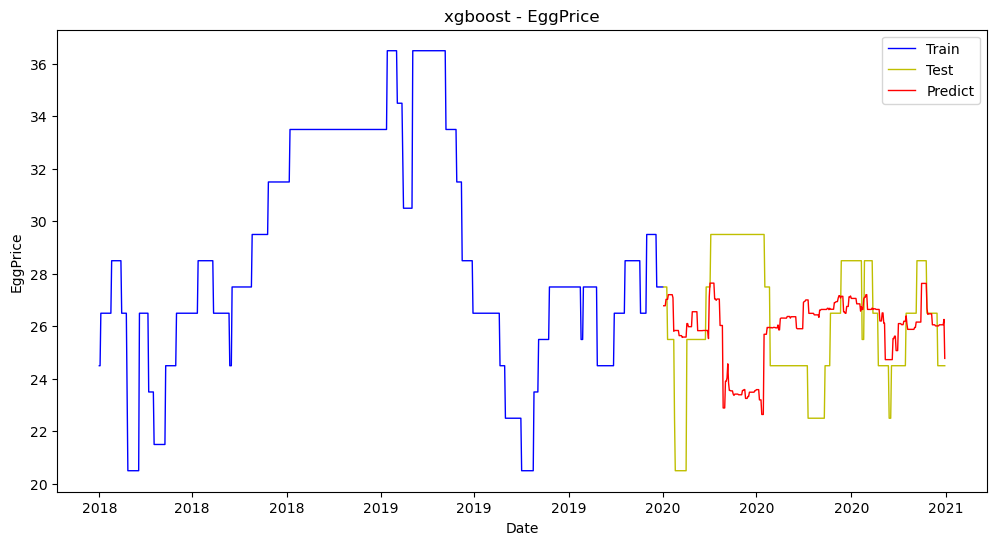

In [78]:
fig = plt.figure(figsize=(12, 6))

plt.title(f"xgboost - EggPrice")


newdate_train = pd.to_datetime(rawdata['Date'][:731])
newdate_test = pd.to_datetime(rawdata['Date'][731:1096])
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
# fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14)) #設定x軸主刻度間距

# plt.xlim([2018, 2023])

x_train = newdate_train
y_train = Train_y
plt.plot(x_train, y_train, 'b', linewidth=1, label="Train")

x_test = newdate_test
y_test = Test_y
# print(y_test)
# y_test = y_test.astype(np.float16) 
plt.plot(x_test,y_test, 'y', linewidth=1, label="Test")

y_pred = output
plt.plot(x_test ,y_pred, 'r', linewidth=1, label="Predict")

plt.xlabel("Date")
plt.ylabel("EggPrice")
plt.legend()

### 增加欄位後

In [101]:
ex_data = pd.read_csv('extended_data.csv')
ex_list = ['NumRuChung_1','NumRuChung_2','NumRuChung_3','NumRuChung_4','NumRuChung_5','NumRuChung_6',
          'NumOfChickLayingEggs_1','NumOfChickLayingEggs_2','NumOfChickLayingEggs_3','NumOfChickLayingEggs_4','NumOfChickLayingEggs_5','NumOfChickLayingEggs_6',
           'BoxesOfEggsPerDay_1','BoxesOfEggsPerDay_2','BoxesOfEggsPerDay_3','BoxesOfEggsPerDay_4','BoxesOfEggsPerDay_5','BoxesOfEggsPerDay_6',
           'NumDisuse_1','NumDisuse_2','NumDisuse_3','NumDisuse_4','NumDisuse_5','NumDisuse_6',
           'NumMoulting_1','NumMoulting_2','NumMoulting_3','NumMoulting_4','NumMoulting_5','NumMoulting_6',
           'WhiteChickQuantity_1','WhiteChickQuantity_2','WhiteChickQuantity_3','WhiteChickQuantity_4','WhiteChickQuantity_5','WhiteChickQuantity_6',
           'RedChickQuantity_1','RedChickQuantity_2','RedChickQuantity_3','RedChickQuantity_4','RedChickQuantity_5','RedChickQuantity_6',
           'ImportChickenQuantity_1','ImportChickenQuantity_2','ImportChickenQuantity_3','ImportChickenQuantity_4','ImportChickenQuantity_5','ImportChickenQuantity_6',
           'Corn_1','Corn_2','Corn_3','Corn_4','Corn_5','Corn_6',
           'SoyBeanFlour_1','SoyBeanFlour_2','SoyBeanFlour_3','SoyBeanFlour_4','SoyBeanFlour_5','SoyBeanFlour_6',
           'CornFlour_1','CornFlour_2','CornFlour_3','CornFlour_4','CornFlour_5','CornFlour_6',
           'DehulledBeanFlour_1','DehulledBeanFlour_2','DehulledBeanFlour_3','DehulledBeanFlour_4','DehulledBeanFlour_5','DehulledBeanFlour_6',
           'HighProteinBeanFlour_1','HighProteinBeanFlour_2','HighProteinBeanFlour_3','HighProteinBeanFlour_4','HighProteinBeanFlour_5','HighProteinBeanFlour_6']

In [102]:
col_list = ['Duckegg_TNN_TaijinPrice', '入中雞雛數', '產蛋隻數',
       '均  日     產蛋箱數', '淘汰隻數', '目  前         換羽隻數',
       'WhiteChickQuantity', 'RedChickQuantity', 'ImportChickenQuantity',
       ' 玉米粒', ' 黃豆粉 ', '玉米粉 ', '脫殼豆粉', '高蛋白豆粉', '臺中_AirTemperatureMean',
       '臺中_AirTemperatureMax', '臺中_Precipitation']

colex_list = ['Duckegg_TNN_TaijinPrice', '入中雞雛數', '產蛋隻數',
       '均  日     產蛋箱數', '淘汰隻數', '目  前         換羽隻數',
       'WhiteChickQuantity', 'RedChickQuantity', 'ImportChickenQuantity',
       ' 玉米粒', ' 黃豆粉 ', '玉米粉 ', '脫殼豆粉', '高蛋白豆粉', '臺中_AirTemperatureMean',
       '臺中_AirTemperatureMax', '臺中_Precipitation',
            'NumRuChung_1','NumRuChung_2','NumRuChung_3','NumRuChung_4','NumRuChung_5','NumRuChung_6',
          'NumOfChickLayingEggs_1','NumOfChickLayingEggs_2','NumOfChickLayingEggs_3','NumOfChickLayingEggs_4','NumOfChickLayingEggs_5','NumOfChickLayingEggs_6',
           'BoxesOfEggsPerDay_1','BoxesOfEggsPerDay_2','BoxesOfEggsPerDay_3','BoxesOfEggsPerDay_4','BoxesOfEggsPerDay_5','BoxesOfEggsPerDay_6',
           'NumDisuse_1','NumDisuse_2','NumDisuse_3','NumDisuse_4','NumDisuse_5','NumDisuse_6',
           'NumMoulting_1','NumMoulting_2','NumMoulting_3','NumMoulting_4','NumMoulting_5','NumMoulting_6',
           'WhiteChickQuantity_1','WhiteChickQuantity_2','WhiteChickQuantity_3','WhiteChickQuantity_4','WhiteChickQuantity_5','WhiteChickQuantity_6',
           'RedChickQuantity_1','RedChickQuantity_2','RedChickQuantity_3','RedChickQuantity_4','RedChickQuantity_5','RedChickQuantity_6',
           'ImportChickenQuantity_1','ImportChickenQuantity_2','ImportChickenQuantity_3','ImportChickenQuantity_4','ImportChickenQuantity_5','ImportChickenQuantity_6',
           'Corn_1','Corn_2','Corn_3','Corn_4','Corn_5','Corn_6',
           'SoyBeanFlour_1','SoyBeanFlour_2','SoyBeanFlour_3','SoyBeanFlour_4','SoyBeanFlour_5','SoyBeanFlour_6',
           'CornFlour_1','CornFlour_2','CornFlour_3','CornFlour_4','CornFlour_5','CornFlour_6',
           'DehulledBeanFlour_1','DehulledBeanFlour_2','DehulledBeanFlour_3','DehulledBeanFlour_4','DehulledBeanFlour_5','DehulledBeanFlour_6',
           'HighProteinBeanFlour_1','HighProteinBeanFlour_2','HighProteinBeanFlour_3','HighProteinBeanFlour_4','HighProteinBeanFlour_5','HighProteinBeanFlour_6'
            ]

orid_ex = pd.DataFrame(columns=colex_list, index=rawdata['Date'])
pd.set_option('mode.chained_assignment', None)
#原有資料
for i in col_list:
    counter =0
    for j in rawdata['Date']:
        orid_ex[i][j] = rawdata[i][counter]
        counter+=1
    if (orid_ex[i].isnull().any()):
        orid_ex[i] = orid_ex[i].fillna(orid_ex[i].mean())

#移動之後的資料
for i in ex_list:
    counter = 0
    for j in rawdata['Date']:
        if(counter < 181):
            orid_ex[i][j]=None
        if(counter>=181):
            k = counter-181
#             print(ex_data[i][k])
            orid_ex[i][j] = ex_data[i][k]
        counter+=1

orid_ex = orid_ex.dropna(axis=0,how='any')
oridata = pd.DataFrame()
for col in colex_list:

    data_pre = np.array(orid_ex[col])
    ## 調整蛋價也normalize
    ##if(col != 'egg_TaijinPrice'):
    data_pre = preprocessing.normalize([data_pre])
    data_pre = data_pre.reshape(1645,1)
    data_pre = pd.DataFrame(data_pre)
    oridata = pd.concat((oridata, data_pre),axis=1)

In [62]:
oridata

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.021892,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021988,0.021535,0.020176,0.020131,0.023051,0.023253,0.023333,0.022645,0.021564,0.021440
1,0.021892,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021988,0.021685,0.020176,0.020131,0.023051,0.023206,0.023285,0.022789,0.021516,0.021440
2,0.021892,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021988,0.021685,0.020176,0.020131,0.023051,0.023285,0.023285,0.022789,0.021516,0.021440
3,0.023260,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021988,0.021685,0.020176,0.020131,0.023051,0.023285,0.023285,0.023029,0.021483,0.021423
4,0.023260,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017476,...,0.021988,0.021685,0.020176,0.020131,0.023051,0.023159,0.023285,0.023029,0.021483,0.021423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.027670,0.029019,0.019814,0.028514,...,0.030456,0.029760,0.028908,0.035721,0.032663,0.032217,0.032460,0.031553,0.030138,0.030350
1641,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.027670,0.029019,0.019814,0.029039,...,0.030456,0.029760,0.028908,0.028304,0.032663,0.032296,0.032460,0.031553,0.030138,0.030350
1642,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.025231,0.031734,0.019814,0.029039,...,0.030456,0.029760,0.017616,0.028304,0.032663,0.032454,0.032460,0.031553,0.031508,0.030350
1643,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.025231,0.031734,0.019814,0.029434,...,0.030456,0.029760,0.017465,0.028304,0.032819,0.032296,0.032460,0.031553,0.031508,0.030350


### 切資料

In [103]:

# 資料只取到 2020
dataset_x = oridata[:][:915]
dataset_y = rawdata['egg_TaijinPrice'][181:1096]

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365)
trainsize

len of dataset:  915


550

In [104]:
### Test 2020 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (550, 95) (550,)
Test data shape:  (365, 95) (365,)


In [105]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(Train_x, Train_y)
output = reg.predict(Test_x)
mse = mean_squared_error(output, Test_y)
mspe = MSPE(output, Test_y)
RMSE = np.sqrt(mse)
print(mse,RMSE,mspe)

5.8187754490074735 2.4122138066530243 0.010603818688885623


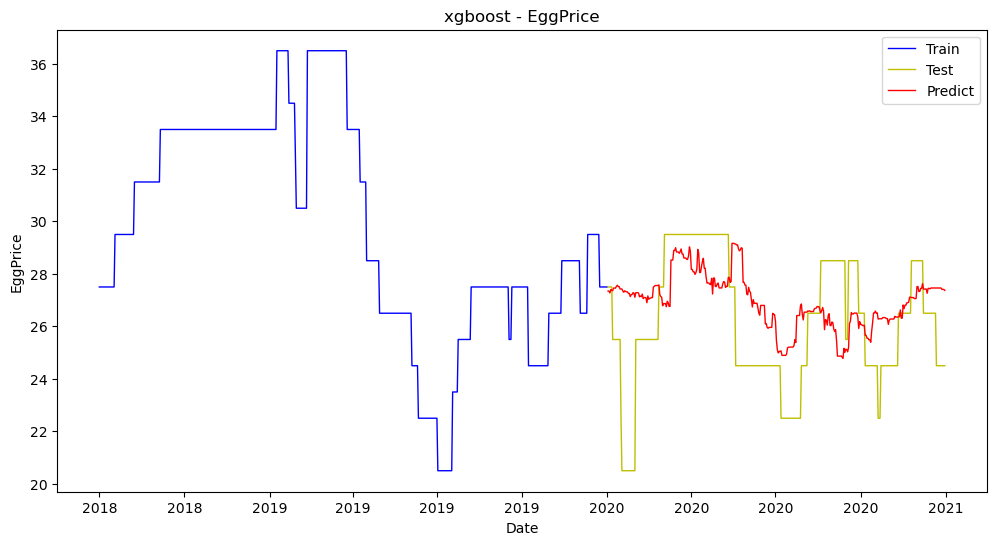

In [70]:
fig = plt.figure(figsize=(12, 6))

plt.title(f"xgboost - EggPrice")

j = 181 +trainsize
k = j + 365
newdate_train = pd.to_datetime(rawdata['Date'][181:j])
newdate_test = pd.to_datetime(rawdata['Date'][j:k])
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
# fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14)) #設定x軸主刻度間距

# plt.xlim([2018, 2023])

x_train = newdate_train
y_train = Train_y
plt.plot(x_train, y_train, 'b', linewidth=1, label="Train")

x_test = newdate_test
y_test = Test_y
# print(y_test)
# y_test = y_test.astype(np.float16) 
plt.plot(x_test,y_test, 'y', linewidth=1, label="Test")

y_pred = output
plt.plot(x_test ,y_pred, 'r', linewidth=1, label="Predict")

plt.xlabel("Date")
plt.ylabel("EggPrice")
plt.legend()